### Plot 'lick-off' sources.  For figure 3.
### Needs to be run separately for each dataset. Then need to run the final cells which aggregate across datasets. 

In [18]:
### Load imports.
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler

import os
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib
import numpy as np
import time
import scipy.stats
import pickle

from collections import defaultdict

import h5py
from scipy.ndimage.filters import gaussian_filter1d
from scipy.stats import zscore
import scipy.stats

import cosmos.traces.trace_analysis_utils as utils
from cosmos.behavior.bpod_dataset import BpodDataset
from cosmos.traces.cell_plotter import CellPlotter
from cosmos.traces.cosmos_traces import CosmosTraces
import cosmos.traces.clustering_utils as cu
import cosmos.params.trace_analyze_params as params 
import statsmodels.stats.multitest as mt


matplotlib.rcParams.update({'xtick.major.pad': '2'})
matplotlib.rcParams.update({'ytick.major.pad': '2'})
matplotlib.rcParams.update({'font.size': 8})
matplotlib.rcParams['pdf.fonttype'] = 42 # truetype
matplotlib.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [19]:
### Set up filepaths.
workstation = 'cosmosdata' #'analysis2'

if workstation == 'analysis2':
    base_dir = '/home/izkula/Dropbox/'
elif workstation == 'cosmosdata':
    base_dir = '/home/user/Dropbox'
    
data_dir = base_dir + '/cosmos_data/'
general_plots_save_dir = base_dir + '/cosmos/trace_analysis/'
fig_save_dir = base_dir + '/cosmos/fig_plots/fig3/pre_lick_sources/'
bpod_dir = base_dir + '/cosmos_data/behavior/'

    
# if not os.path.isdir(fig_save_dir):
os.makedirs(fig_save_dir, exist_ok=True)

In [20]:


# datasets = [7, 11, 18, 19, 35]
dataset_id = 35
mouse_colors = utils.get_colors(4, plt.cm.spectral);


20181014 rasgrf2m4263_COSMOSTrainMultiBlockGNG_1
(1/3) Loading trace data.
(2/3) Loading behavior data.
While loading bpod, enforcing that ntrials is:246
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
Saving to:  /home/user/Dropbox/cosmos/trace_analysis/20181014/rasgrf2m4263_COSMOSTrainMultiBlockGNG_1/polar_pre-reward.pdf
Saving to:  /home/user/Dropbox/cosmos/trace_analysis/20181014/rasgrf2m4263_COSMOSTrainMultiBlockGNG_1/polar_post-reward.pdf
Saving to:  /home/user/Dropbox/cosmos/trace_analysis/20181014/rasgrf2m4263_COSMOSTrainMultiBlockGNG_1/licks.pdf
Saving to:  /home/user/Dropbox/cosmos/trace_analysis/20181014/rasgrf2m4263_COSMOSTrainMultiBlockGNG_1/success_rate.pdf
LED trials: 247
Processing traces.
[-62.92161992 461.92161992]
[306.95981814 334.04018186]
Elapsed time: 25.44269847869873


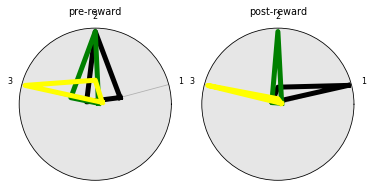

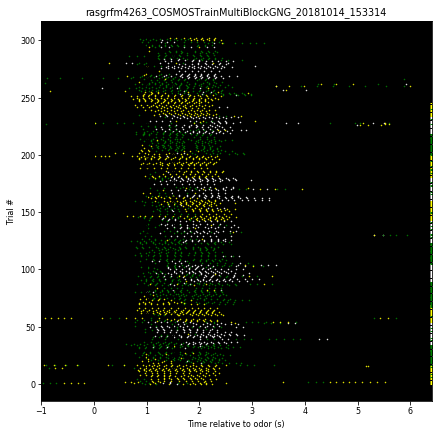

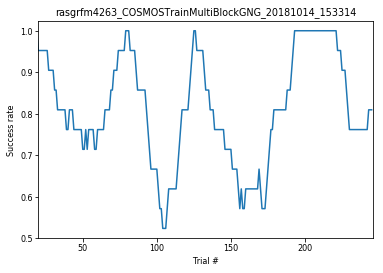

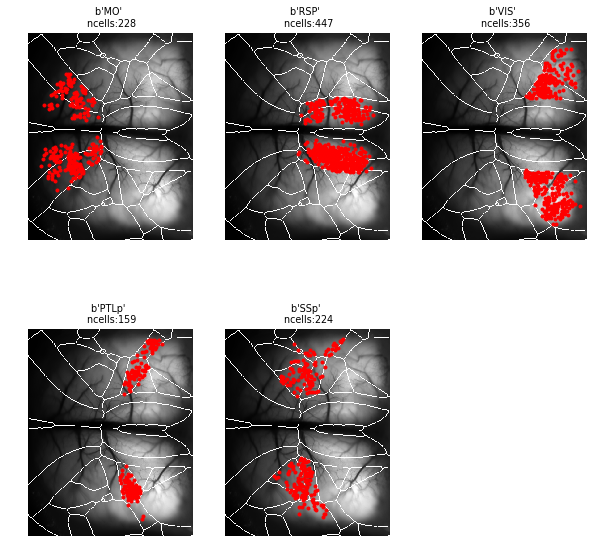

In [21]:
# Load all of the datasets (each their own class).
dataset = params.DATASETS[dataset_id]
print(dataset['date'], dataset['name'])
dataset['data_root'] = data_dir
dataset['fig_save_dir'] = general_plots_save_dir
dataset['behavior_dir'] = bpod_dir

startt = time.time()
CT = CosmosTraces(dataset, do_region_plots=True)
BD = CT.bd
print('Elapsed time: '+str(time.time() - startt))

In [22]:
# Setup some analysis specific variables.
smooth_spikes = gaussian_filter1d(CT.St, 1.5, axis=1, mode='constant')
if BD is not None:

    # Define trial sets.
    use_all_trials = True

    if use_all_trials:
        clean_trials = np.ones(BD.success.shape)
        min_block_trial = 0
#         success = np.ones(BD.success.shape)
        success = BD.success
    else:
        clean_trials = np.zeros(BD.success.shape)
        clean_trials[BD.get_clean_trials(min_selectivity=0.75)] = 1
        min_block_trial = 4
        success = BD.success


    lick_spout1 = np.logical_and.reduce((BD.go_trials.astype('bool'), 
                                         success, 
                                         BD.spout_positions==1,
                                         BD.ind_within_block>=min_block_trial,
                                         clean_trials))
    lick_spout3 = np.logical_and.reduce((BD.go_trials.astype('bool'), 
                                         success, 
                                         BD.spout_positions==3,
                                         BD.ind_within_block>=min_block_trial, 
                                         clean_trials))
    lick_spout4 = np.logical_and.reduce((BD.go_trials.astype('bool'), 
                                         success, 
                                         BD.spout_positions==4,
                                         BD.ind_within_block>=min_block_trial, 
                                         clean_trials))
    nolick = np.logical_and.reduce((~BD.go_trials.astype('bool'), 
                                    success))

    trial_sets = (lick_spout1, lick_spout3, lick_spout4, nolick)
    trial_names = ('go1', 'go2', 'go3', 'ng')
else:
    trial_sets = None
    trial_names = None

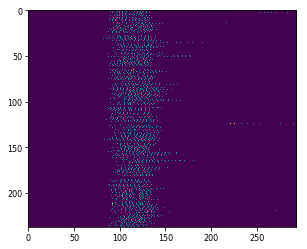

In [23]:
### Set things up
traces = smooth_spikes
summed_licks = sum([CT.bd.spout_lick_rates[i] for i in range(4)])
pre_lick_trials = np.sum(summed_licks[:, :74], axis=1) > 0
no_pre_lick_trials = ~pre_lick_trials
plt.imshow(summed_licks[no_pre_lick_trials])

In [24]:
### Get cells with significantly more activity during pre vs. post, across trials
ranges = dict()
ranges['pre'] = np.arange(15, 72)
ranges['post'] = np.arange(76, 133)
traces = smooth_spikes

sorted_sig_cells = cu.get_sources_more_active_pre_vs_post(traces, trial_sets, ranges, 
                                                          no_pre_lick_trials,
                                                          pthresh=1e-3)

/home/user/anaconda3/envs/cosmostools3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


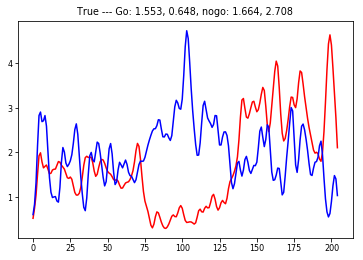

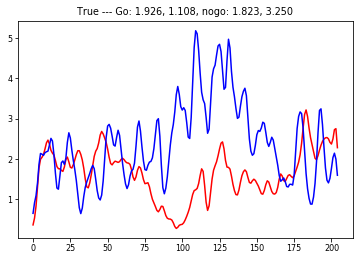

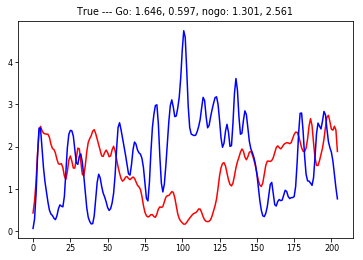

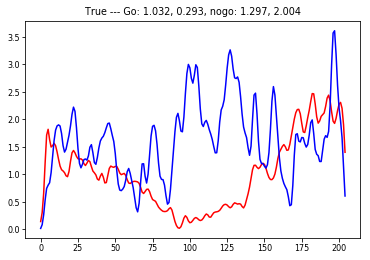

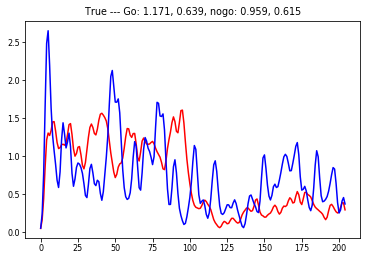

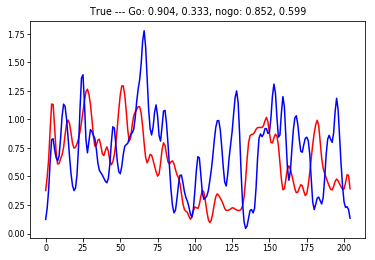

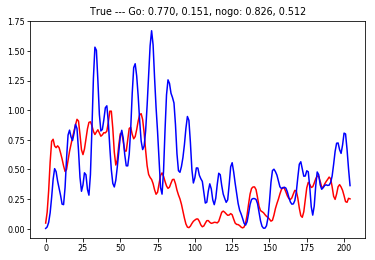

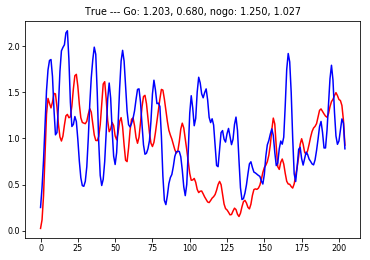

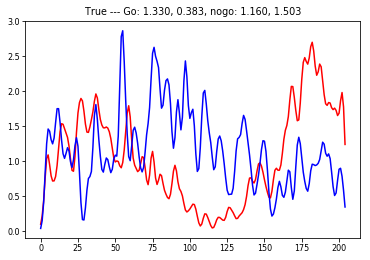

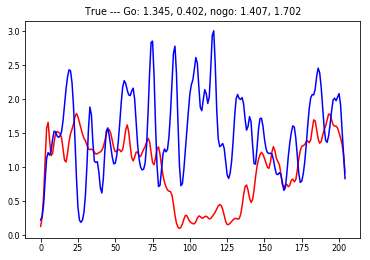

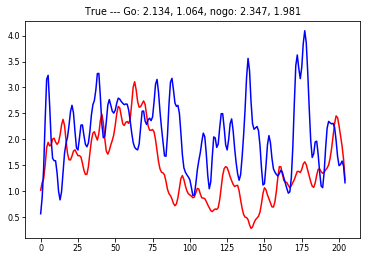

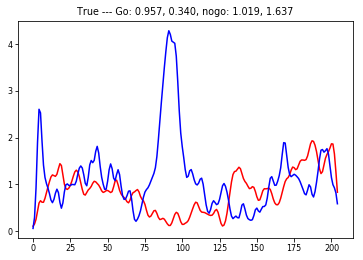

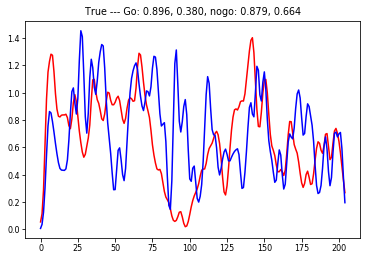

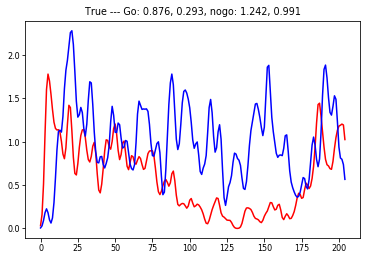

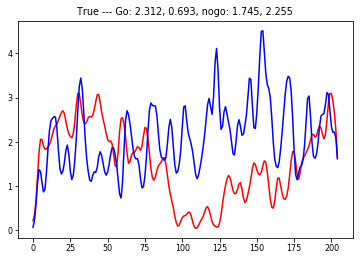

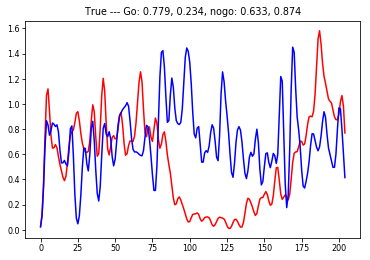

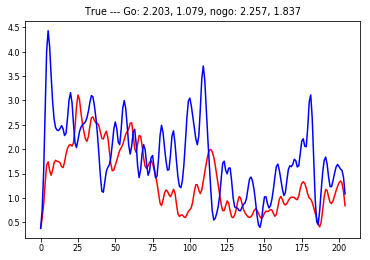

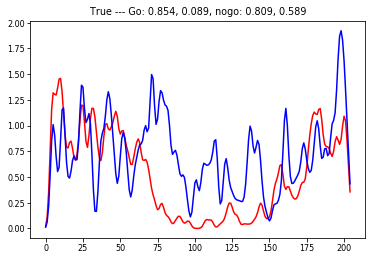

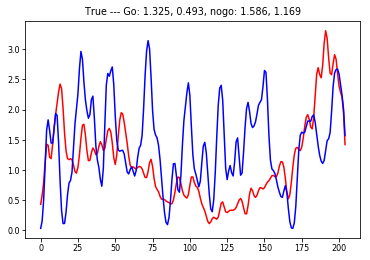

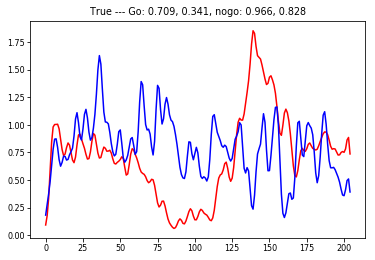

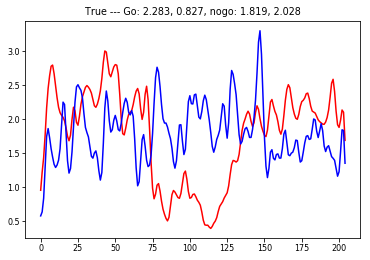

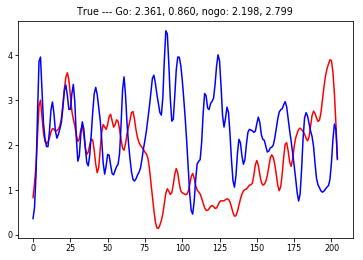

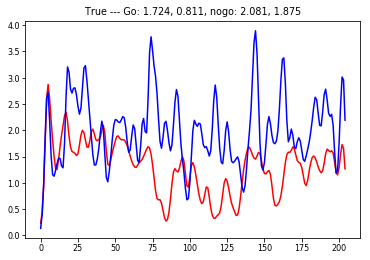

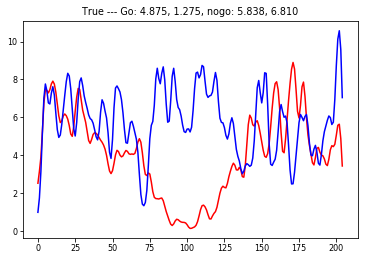

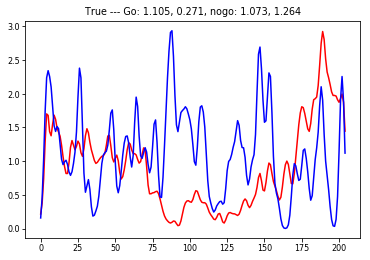

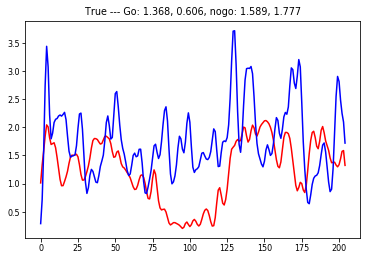

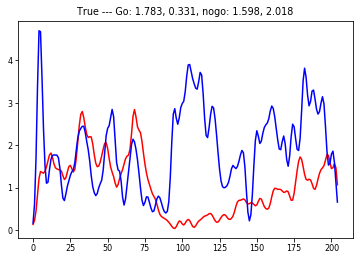

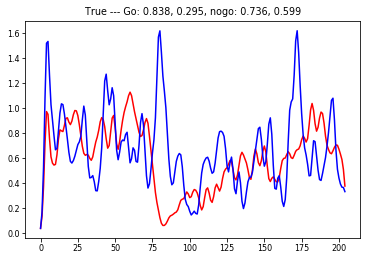

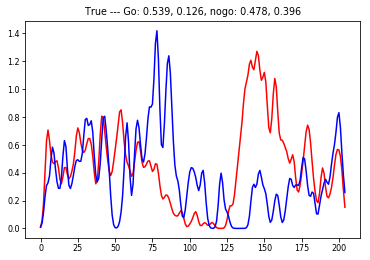

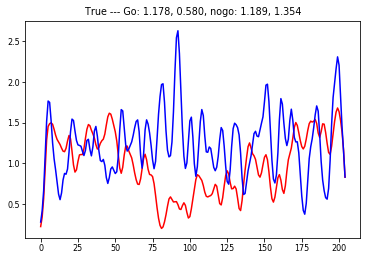

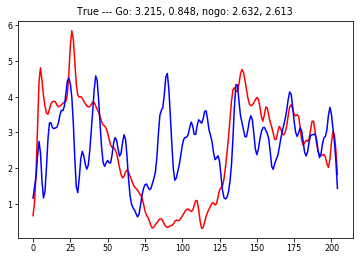

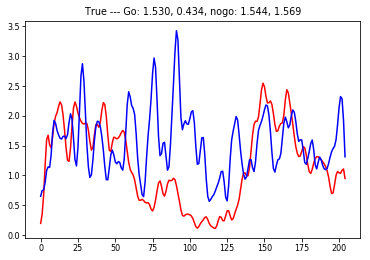

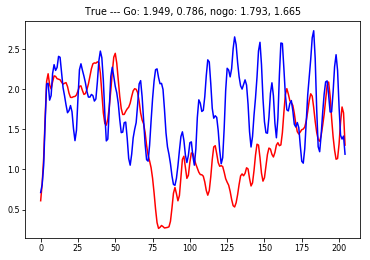

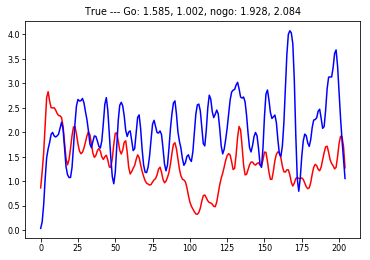

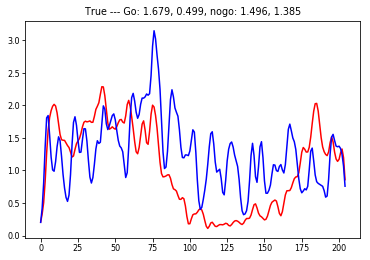

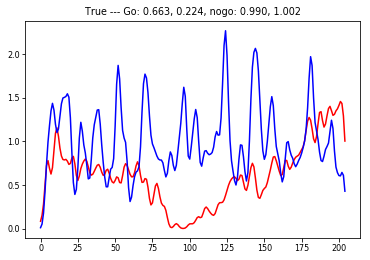

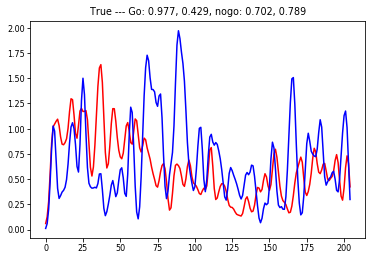

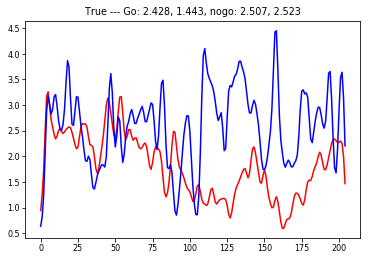

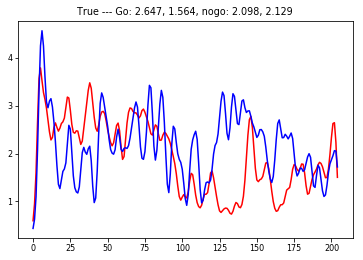

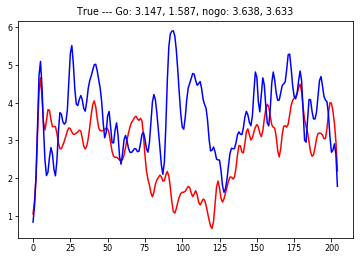

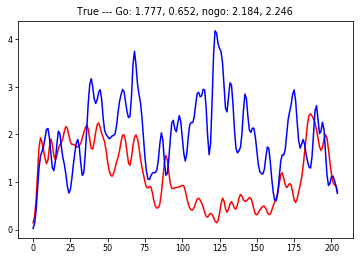

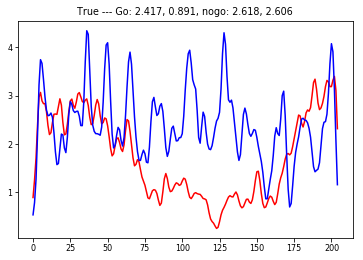

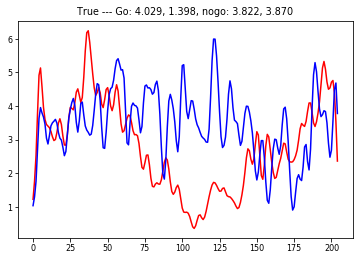

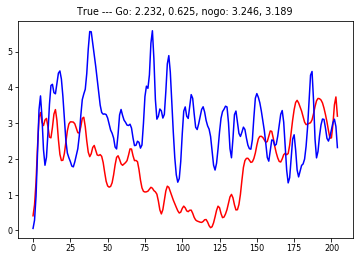

In [25]:
### Get cells that decrease on go trials, but not on nogo

go_trials = np.logical_or.reduce((trial_sets[0], trial_sets[1], trial_sets[2]))
nogo_trials = trial_sets[-1]
which_cells = sorted_sig_cells
good_cells = cu.get_sources_decrease_on_go_and_flat_on_nogo(which_cells, traces,
                                                            go_trials, nogo_trials, ranges,
                                                            use_std_thresh=True, do_plot=True)

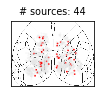

In [26]:
### Plot these cells

cu.plot_centroids(good_cells, CT)
plt.title('# sources: {}'.format(len(good_cells)))
savename = 'id'+str(dataset_id)+'_decreasing_cells_locs.pdf'
plt.gcf().set_size_inches(w=1.5, h=1.5) # Control size of figure in inches
plt.savefig(os.path.join(fig_save_dir, savename), 
            transparent=True, rasterized=True, dpi=600) 

/home/user/Dropbox/cosmos/fig_plots/fig3/pre_lick_sources/id35_mean_across_cells.pdf.npz


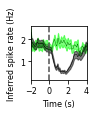

In [27]:
### Plot mean trace from these cells
which_cells = good_cells
odor_onset_frame = 64
xt = np.arange(traces.shape[1])/CT.fps - odor_onset_frame/CT.fps

plt.figure()
### Convert to spike rate?
# go_mean = np.mean(np.mean(traces[which_cells, :, :][:, :, go_trials]*CT.fps
# nogo_mean = np.mean(np.mean(traces[which_cells, :, :][:, :, nogo_trials]*CT.fps
go_mean = np.mean(np.mean(traces[which_cells, :, :][:, :, go_trials], axis=0).T, axis=0)
nogo_mean = np.mean(np.mean(traces[which_cells, :, :][:, :, nogo_trials], axis=0).T, axis=0)
go_sem= scipy.stats.sem(np.mean(traces[which_cells, :, :][:, :, go_trials], axis=2), axis=0)
nogo_sem = scipy.stats.sem(np.mean(traces[which_cells, :, :][:, :, nogo_trials], axis=2), axis=0)

plt.plot(xt, nogo_mean, 'g', linewidth=0.5)
plt.plot(xt, go_mean, 'k', linewidth=0.5)
plt.fill_between(xt, nogo_mean-nogo_sem, nogo_mean+nogo_sem, color=[0, 1, 0, 0.5])
plt.fill_between(xt, go_mean-go_sem, go_mean+go_sem, color=[0, 0, 0, 0.5])
plt.ylabel('Inferred spike rate (Hz)')
plt.xlabel('Time (s)')
plt.axvline(0, color=[0.3,0.3,0.3], linestyle='--')

savename = 'id'+str(dataset_id)+'_mean_across_cells.pdf'
plt.gcf().set_size_inches(w=1, h=1) # Control size of figure in inches
plt.xticks([-2, 0, 2, 4])
plt.xlim([-2, 4])
plt.savefig(os.path.join(fig_save_dir, savename), 
            transparent=True, rasterized=True, dpi=600) 

fname = os.path.join(fig_save_dir, savename + '.npz')
print(fname)
with open(fname, 'wb') as f:
    np.savez(f, go_mean=go_mean, nogo_mean=nogo_mean, which_cells=which_cells, ncells=CT.ncells)

In [28]:
lick_onsets = utils.get_lick_onsets(CT.bd.spout_lick_rates)


/home/user/anaconda3/envs/cosmostools3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


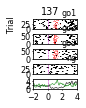

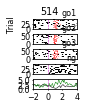

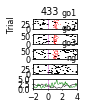

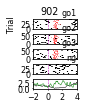

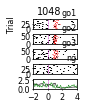

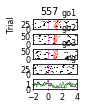

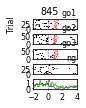

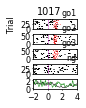

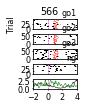

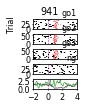

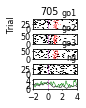

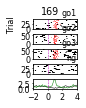

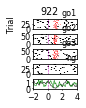

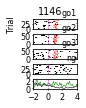

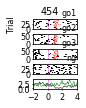

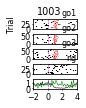

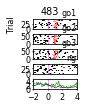

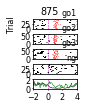

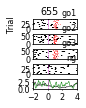

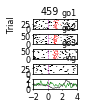

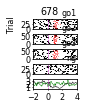

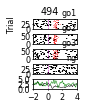

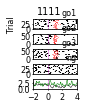

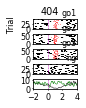

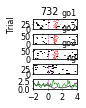

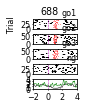

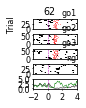

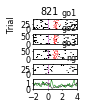

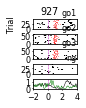

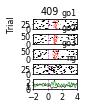

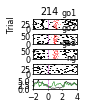

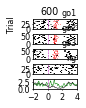

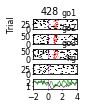

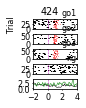

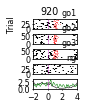

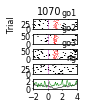

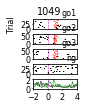

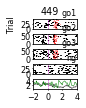

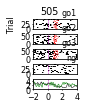

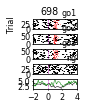

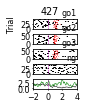

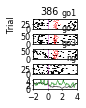

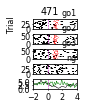

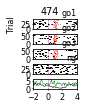

In [29]:
### Plot individual sources
do_plot = True
save_dir = os.path.join(fig_save_dir, 'indiv_sources_{}'.format(dataset_id))
os.makedirs(save_dir, exist_ok=True)
if do_plot:
    event_frames = CT.fps*np.array([CT.bd.stimulus_times[0], 
                            CT.bd.stimulus_times[0]+1.5])  
    for i in which_cells[:]:
        trial_colors = ['orange', 'c', 'r', 'k']  
        utils.plot_formatted_cell_across_trials(i, traces, CT.Tt, 
                                                trial_sets[:], trial_names, trial_colors, 
                                                event_frames, centroids=None, atlas_tform=None, 
                                                clim=[0, 5], do_merge_go_means=True,
                                                use_trials=no_pre_lick_trials,
                                                lick_onsets=lick_onsets,
                                                xlims=[-2, 4])
        savename = 'id'+str(dataset_id)+'_cell_{}.pdf'.format(i)
        plt.gcf().set_size_inches(w=0.75, h=1.3) # Control size of figure in inches
        plt.xticks([-2, 0, 2, 4])
        plt.savefig(os.path.join(save_dir, savename), 
                    transparent=True, rasterized=True, dpi=600) 

### Make a summary plot across mice

In [30]:
### Load all datasets
all_go_mean = []
all_nogo_mean = []
all_frac_cells = []
for d_id in [7, 11, 18, 19]:
# for d_id in [19]:
    savename = 'id'+str(d_id)+'_mean_across_cells.pdf'
    fname = os.path.join(fig_save_dir, savename + '.npz')
    with open(fname, 'rb') as f:
        out = np.load(f)
        all_go_mean.append(out['go_mean'])
        all_nogo_mean.append(out['nogo_mean'])
        all_frac_cells.append(len(out['which_cells'])/out['ncells'])

        
all_go_mean = np.vstack(all_go_mean)
all_nogo_mean = np.vstack(all_nogo_mean)

In [31]:
all_frac_cells

[0.024193548387096774,
 0.012915129151291513,
 0.018026565464895637,
 0.017130620985010708]

In [32]:
print('Fraction of cells that are lick-off: mean {:.3f}, std {:.3f}, sem {:.3f}'.format(np.mean(all_frac_cells),
                                                                        np.std(all_frac_cells),
                                                                        scipy.stats.sem(all_frac_cells)))

Fraction of cells that are lick-off: mean 0.018, std 0.004, sem 0.002


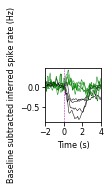

In [33]:
### Now plot across datasets

odor_onset_frame = 64
for i in range(all_go_mean.shape[0]):
    plt.plot((np.arange(all_go_mean.shape[1])-odor_onset_frame)/CT.fps, 
             all_go_mean[i, :]-np.mean(all_go_mean[i, :10]), 'k', linewidth=0.5)
    plt.plot((np.arange(all_nogo_mean.shape[1])-odor_onset_frame)/CT.fps, 
             all_nogo_mean[i, :]-np.mean(all_nogo_mean[i, :10]), 'g', linewidth=0.5)
plt.axvline(0, linestyle='--', color='m', linewidth=0.5)
plt.xlim([-2, 4])
plt.ylabel('Baseline subtracted inferred spike rate (Hz)')
savename = 'all_mice_baseline_subtracted_mean.pdf'.format(i)
plt.gcf().set_size_inches(w=1, h=1) # Control size of figure in inches
plt.xticks([-2, 0, 2, 4])
plt.xlabel('Time (s)')
plt.savefig(os.path.join(fig_save_dir, savename), 
            transparent=True, rasterized=True, dpi=600) 

In [34]:
raise('done')

TypeError: exceptions must derive from BaseException